In [ ]:
import numpy as np
from dataclasses import dataclass
import random 
n=13

@dataclass
class Parameters:
    insulin_plasma_fat: float
    insulin_fat_plasma: float

    V_fat: float

    fattyacids_plasma_fat: float
    fattyacids_fat_plasma: float

    glucose_plasma_fat: float
    glucose_fat_plasma: float

    aminoacids_plasma_fat: float
    aminoacids_fat_plasma: float



    V_plasma: float


    glucose_to_g6p: float
    g6p_to_glucose: float

    CLinsulin: float

    g6p_to_pyruvate: float 
    pyruvate_to_g6p: float


    pyruvate_to_acetylcoa: float 

    acetylcoa_to_fattyacids: float  

    fattyacids_to_acetylcoa: float  
    aminoacids_to_acetylcoa: float   

    fattyacids_to_triglycerides: float
    triglycerides_to_fattyacids: float

    
    

p = Parameters(
    insulin_plasma_fat=1,         
    insulin_fat_plasma=0.1,            
    V_fat=10.0,
    #give or take 1-2 liters. Usually 2-3 liters less on average for women
    # visceral fat is about 10% of total fat volume                       
    
    fattyacids_plasma_fat=2,         
    fattyacids_fat_plasma=0.2,        

    glucose_plasma_fat=1,            
    glucose_fat_plasma=0.1,            

    aminoacids_plasma_fat=1,
    aminoacids_fat_plasma=0.1,

    V_plasma=5.0,                                


    glucose_to_g6p=1,
    g6p_to_glucose=0.1,


    CLinsulin = 1,
    
    g6p_to_pyruvate=1,
    pyruvate_to_g6p=0.1,

    # Acetyl-CoA & TCA
    pyruvate_to_acetylcoa=1,
    
    acetylcoa_to_fattyacids=1,


    # Alternative fuels
    fattyacids_to_acetylcoa=1/8,
    
    aminoacids_to_acetylcoa=1/4,
    

    # Anaerobic respiration
    fattyacids_to_triglycerides=1,
    triglycerides_to_fattyacids=0.0005
)

# 0 glucose plasma
# 1 glucose fat
# 2 insulin plasma
# 3 insulin fat
# 4 fattyacids plasma
# 5 fattyacids fat
# 6 aminoacids plasma
# 7 aminoacids fat
# 8 g6p fat
# 9 triglycerides fat
# 10 Pyruvate
# 11 acetylcoa fat
# 12 ROS fat

#start with 10 kg of triglycerides in adipose tissue
# make volume change with amount of fat
# 1.1 g of 
#adipose .9g/ml
#doesnt have to be part of the diffeq, cuz you can calculate the amount after
#feed to visceral fat should be higher
#major diff btwn the two is subcut is fed by vasculature, (flow is through plasma)
# visceral is by its vascular also, but leakage from capillaries around gut and portal vein and triglycerides that go from chylomicrons to lymph
# when they leave endothelial, exocytosed into extracellular fluid which is in and around visceral fat
#fine to represent as higher uptake amount


def fat(t,y,p):
    dydt = np.zeros(n)

    dglucose = glucose(t,y,p)
    dinsulin = insulin(t,y,p)
    dfattyacids = fattyacids(t,y,p)
    daminoacids = aminoacids(t,y,p)
    dg6p = g6p(t,y,p)
    dtriglycerides = triglycerides(t,y,p)
    dpyruvate = pyruvate(t,y,p)
    dacetylcoa = acetylcoa(t,y,p)
    dROS = ROS(t,y,p)
  
    
    dydt = dglucose+dinsulin+dfattyacids+daminoacids+dg6p+dtriglycerides+dpyruvate+dacetylcoa+dROS
    return dydt

def glucose(t, y, p):
    dydt = np.zeros(n)
    dydt[0] = (
        (-p.glucose_plasma_fat * y[0] * p.V_plasma + p.glucose_fat_plasma * y[1] * p.V_fat) / p.V_plasma
    )
    dydt[1] = (
        (p.glucose_plasma_fat * y[0] * p.V_plasma - p.glucose_fat_plasma * y[1] * p.V_fat) / p.V_fat
        -p.glucose_to_g6p * y[1] + p.g6p_to_glucose *y[8]
    )
    return dydt

def insulin(t, y, p):
    dydt = np.zeros(n)
    dydt[2] = ((-p.insulin_plasma_fat * y[2] *p.V_plasma + p.insulin_fat_plasma * y[3] * p.V_fat) / p.V_plasma
               )
    dydt[3] = ((p.insulin_plasma_fat * y[2] *p.V_plasma - p.insulin_fat_plasma * y[3] * p.V_fat) / p.V_fat
               -p.CLinsulin*y[3])
    return dydt

def fattyacids(t, y, p):
    Km=1
    dydt = np.zeros(n)
    dydt[4] = ((-p.fattyacids_plasma_fat * y[4] * p.V_plasma + p.fattyacids_fat_plasma * y[5] * p.V_fat) / p.V_plasma
               )
    dydt[5] = ((p.fattyacids_plasma_fat * y[4] * p.V_plasma - p.fattyacids_fat_plasma * y[5] * p.V_fat) / p.V_fat
               -p.fattyacids_to_acetylcoa * y[5]
               -3*(p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 +3*p.triglycerides_to_fattyacids*y[9]
               + p.acetylcoa_to_fattyacids *y[11])
    
    return dydt



def aminoacids(t, y, p):
    dydt = np.zeros(n)
    dydt[6] = ((-p.aminoacids_plasma_fat * y[6] * p.V_plasma + p.aminoacids_fat_plasma * y[7] * p.V_fat) / p.V_plasma
               )
    dydt[7] = ((p.aminoacids_plasma_fat * y[6] * p.V_plasma - p.aminoacids_fat_plasma * y[7] * p.V_fat) / p.V_fat
               - p.aminoacids_to_acetylcoa * y[7])
    return dydt

def g6p(t,y,p):
    dydt = np.zeros(n)
    
    dydt[8] = (
        p.glucose_to_g6p * y[1] - p.g6p_to_glucose *y[8]
        -p.g6p_to_pyruvate * y[8] + p.pyruvate_to_g6p *y[10]**2 
    )
    return dydt

def triglycerides(t,y,p):
    dydt = np.zeros(n)

    Km= 1
    
    dydt[9] = (
        (p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 -p.triglycerides_to_fattyacids*y[9]
    )
    return dydt

def pyruvate(t,y,p):
    dydt = np.zeros(n)
    dydt[10] =  (2* p.g6p_to_pyruvate * y[8] - 2*p.pyruvate_to_g6p *y[10]**2 
                - p.pyruvate_to_acetylcoa * y[10] 
                )
    return dydt

def acetylcoa(t,y,p):
    dydt = np.zeros(n)
    dydt[11] = (p.pyruvate_to_acetylcoa * y[10] + 8*p.fattyacids_to_acetylcoa * y[5]  + p.aminoacids_to_acetylcoa * y[7]
                - 8*p.acetylcoa_to_fattyacids *y[11])
    return dydt
#assume 16 carbon chain (palmitic acid)

def ROS(t,y,p):
    #might include a randomness aspect here. not sure what the probability will be
    ROSpercent = 0.01
    Km=1
    #https://www.ncbi.nlm.nih.gov/books/NBK500351/
    #1-2% of molecular oxygen is converted to superoxide owing to electron elak
    dydt = np.zeros(n)
    dydt[12] = ROSpercent*(
                +p.fattyacids_to_acetylcoa * y[5] + p.aminoacids_to_acetylcoa * y[7]
                +3*(p.fattyacids_to_triglycerides*p.V_fat*y[5]/(Km+y[5]*p.V_fat))**3 +3*p.triglycerides_to_fattyacids*y[9]
                + 8*p.acetylcoa_to_fattyacids *y[11])

    return dydt


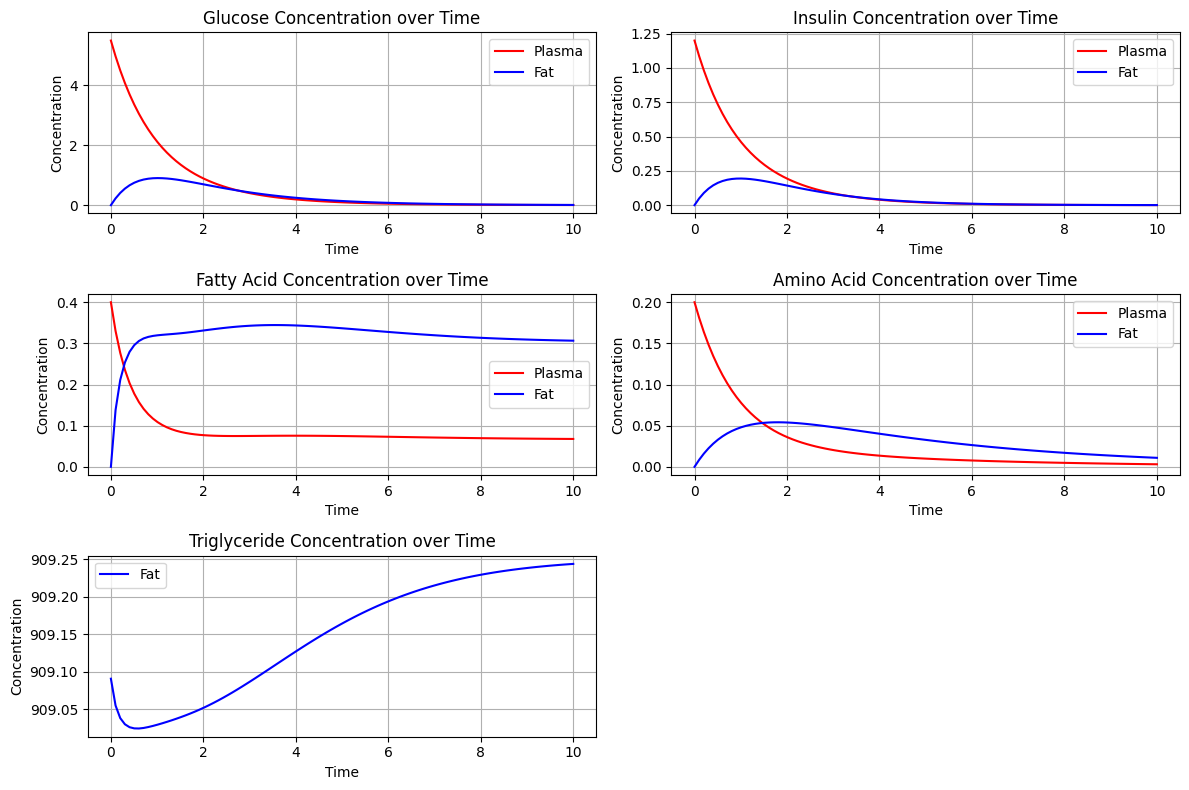

In [ ]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

#
# TRY NUMPY.RAND
# check metabolical for ROS generation
# beta oxidation of fatty acids
#
y0 = np.zeros(n)
y0[0] = 5.5 #gmmol
y0[2] = 1.2 #g/L
y0[4] = 0.4 #mmol/L
y0[6] = 0.2 #mmol/L
y0[9] = 10 * 1000 /p.V_fat




t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)


solution = solve_ivp(fun=lambda t, y: fat(t, y, p),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='LSODA')

timespan = solution.t   
glucoseplasma = solution.y[0]
glucosefat = solution.y[1]
triglycerides = solution.y[9]

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(timespan, glucoseplasma, label='Plasma', color='red')
plt.plot(timespan, glucosefat, label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Glucose Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(timespan, solution.y[2], label='Plasma', color='red')
plt.plot(timespan, solution.y[3], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Insulin Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3)
plt.plot(timespan, solution.y[4], label='Plasma', color='red')
plt.plot(timespan, solution.y[5], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fatty Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(timespan, solution.y[6], label='Plasma', color='red')
plt.plot(timespan, solution.y[7], label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Amino Acid Concentration over Time')
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 5)
plt.plot(timespan, triglycerides, label='Fat', color='blue')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Triglyceride Concentration over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

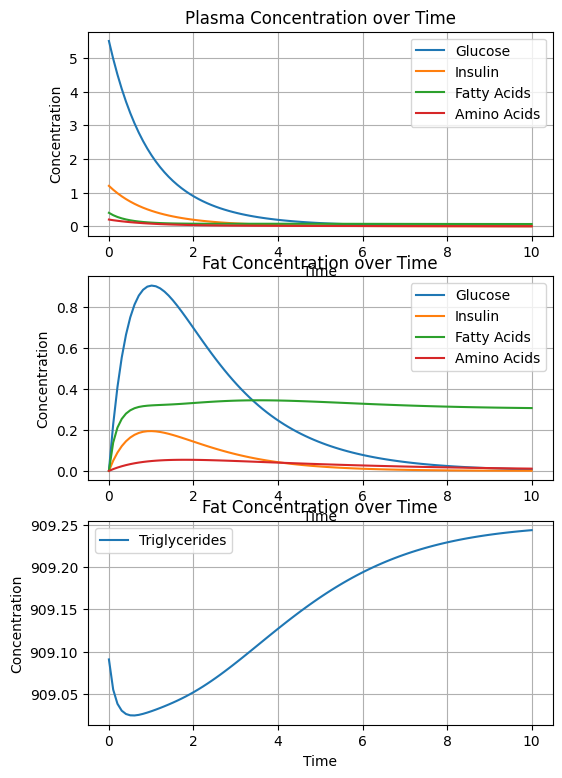

In [135]:
plt.figure(figsize=(6, 9))
plt.subplot(3, 1, 1)
plt.plot(timespan, solution.y[0], label='Glucose')
plt.plot(timespan, solution.y[2], label='Insulin')
plt.plot(timespan, solution.y[4], label='Fatty Acids')
plt.plot(timespan, solution.y[6], label='Amino Acids')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Plasma Concentration over Time')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 2)
plt.plot(timespan, solution.y[1], label='Glucose')
plt.plot(timespan, solution.y[3], label='Insulin')
plt.plot(timespan, solution.y[5], label='Fatty Acids')
plt.plot(timespan, solution.y[7], label='Amino Acids')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fat Concentration over Time')
plt.legend()
plt.grid(True)
plt.subplot(3, 1, 3)

plt.plot(timespan, solution.y[9], label='Triglycerides')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fat Concentration over Time')
plt.legend()
plt.grid(True)

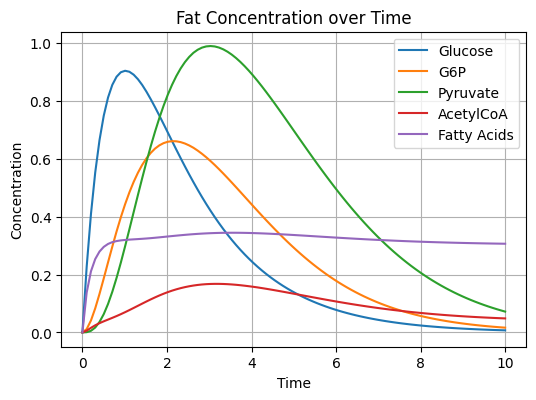

In [136]:
plt.figure(figsize=(6, 9))
plt.subplot(2, 1, 1)
plt.plot(timespan, solution.y[1], label='Glucose')
plt.plot(timespan, solution.y[8], label='G6P')
plt.plot(timespan, solution.y[10], label='Pyruvate')
plt.plot(timespan, solution.y[11], label='AcetylCoA')
plt.plot(timespan, solution.y[5], label='Fatty Acids')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Fat Concentration over Time')
plt.legend()
plt.grid(True)


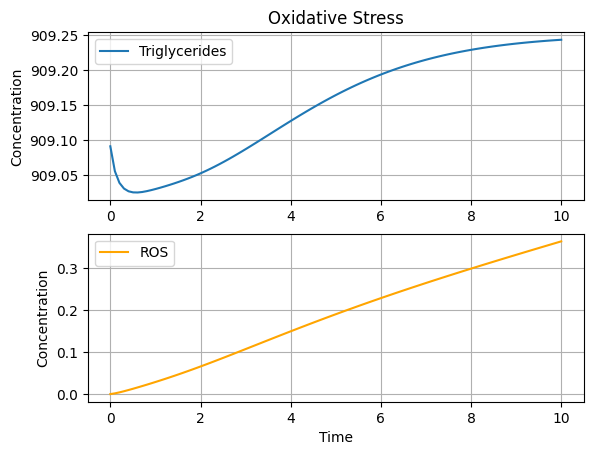

In [137]:
plt.subplot(2, 1, 1)
plt.plot(timespan, triglycerides, label='Triglycerides')


plt.ylabel('Concentration')
plt.title('Oxidative Stress')
plt.legend()
plt.grid(True)
plt.subplot(2, 1, 2)

plt.plot(timespan, solution.y[12], label='ROS', color='orange')
plt.xlabel('Time')
plt.ylabel('Concentration')

plt.legend()
plt.grid(True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


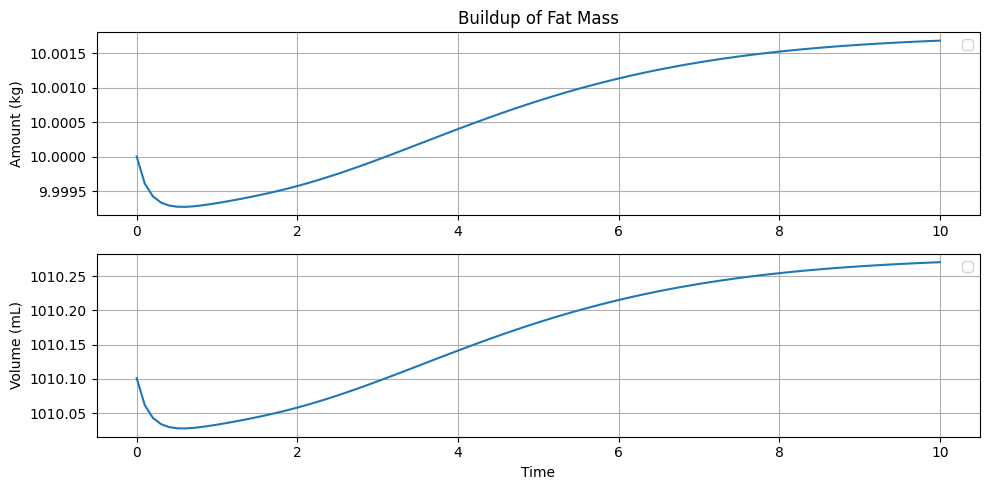

In [149]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(10, 5))

# First subplot
ax1 = plt.subplot(2, 1, 1)
ax1.plot(timespan, triglycerides * p.V_fat / 1000)
ax1.set_ylabel('Amount (kg)')
ax1.set_title('Buildup of Fat Mass')
ax1.legend()
ax1.grid(True)

# Disable scientific notation on y-axis of subplot 1
formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
ax1.yaxis.set_major_formatter(formatter)

# Second subplot
ax2 = plt.subplot(2, 1, 2)
ax2.plot(timespan, triglycerides / 0.9)
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume (mL)')
ax2.legend()
ax2.grid(True)

# Disable scientific notation on y-axis of subplot 2
formatter2 = ScalarFormatter(useMathText=False)
formatter2.set_scientific(False)
formatter2.set_useOffset(False)
ax2.yaxis.set_major_formatter(formatter2)

plt.tight_layout()
plt.show()
